In [1]:
import numpy as np

def rmse(y, yhat):
    return np.mean((y - yhat)**2)

In [2]:
np.random.seed(123)
n = 10000
nval = 5000
Z = np.random.uniform(0, 1, size=n)
dgp = 2

In [3]:
if dgp == 1:
    # dgp that favors the x-learner
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * np.ones(z.shape)

In [4]:
if dgp == 2:
    # dgp that favors the dr-learner
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: (.5 + .1 * (z<=.4) * (z>=.2))

In [5]:
if dgp == 3:
    # dgp that favors the r-learner
    prop = lambda z: .5 - .49 * (z<=.6) * (z>=.3)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * z**2

In [6]:
if dgp == 4:
    # dgp that favors the covariate shift X-learner over X-learner
    prop = lambda z: .5 - .49 * (z<=.6) * (z>=.3)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * z**2 * (z<=.6) + .18

In [7]:
if dgp == 5:
    # dgp that removes superiority of X-learner strategy
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * np.ones(z.shape)
    cate = lambda z: .5 * (z<=.8) * (z>=.5)

In [8]:
if dgp == 6:
    # dgp that favors the opposite of the X-learner strategy
    prop = lambda z: .95 * np.ones(z.shape)
    base = lambda z: .1 * np.ones(z.shape)
    cate = lambda z: .5 * (z<=.8) * (z>=.5)

In [9]:
D = np.random.binomial(1, prop(Z))
Y = cate(Z) * D + base(Z) + np.random.normal(0, .05, size=n)

In [10]:
ntest = 1000
Ztest = np.random.uniform(0, 1, size=ntest)
Ztest = np.sort(Ztest)

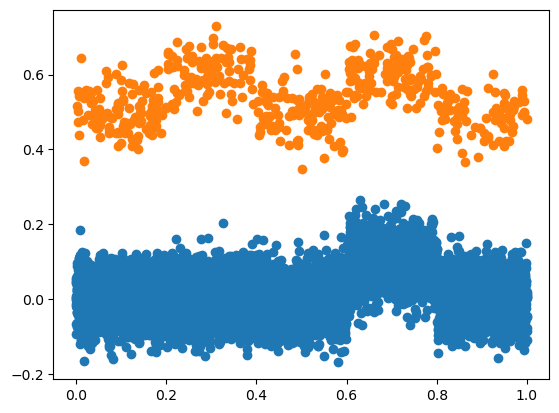

In [11]:
import matplotlib.pyplot as plt

plt.scatter(Z[D==0], Y[D==0])
plt.scatter(Z[D==1], Y[D==1])
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

param_grid = {
    'max_depth': [2, 5, 9],
    'min_samples_leaf': [20, 50]
}
reg = lambda: GridSearchCV(RandomForestRegressor(random_state=123), param_grid)
clf = lambda: GridSearchCV(RandomForestClassifier(random_state=123), param_grid)

In [13]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)])
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val])
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)])
        return self

reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20, verbosity=0)
clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0)

In [14]:
Z = Z.reshape(-1, 1)
g0 = reg().fit(Z[D==0], Y[D==0])
g1 = reg().fit(Z[D==1], Y[D==1])

[0]	validation_0-rmse:0.45946
[1]	validation_0-rmse:0.43668
[2]	validation_0-rmse:0.41506
[3]	validation_0-rmse:0.39454
[4]	validation_0-rmse:0.37506
[5]	validation_0-rmse:0.35657
[6]	validation_0-rmse:0.33902
[7]	validation_0-rmse:0.32237
[8]	validation_0-rmse:0.30657
[9]	validation_0-rmse:0.29158
[10]	validation_0-rmse:0.27736
[11]	validation_0-rmse:0.26387
[12]	validation_0-rmse:0.25109
[13]	validation_0-rmse:0.23896
[14]	validation_0-rmse:0.22747
[15]	validation_0-rmse:0.21659
[16]	validation_0-rmse:0.20627
[17]	validation_0-rmse:0.19650
[18]	validation_0-rmse:0.18725
[19]	validation_0-rmse:0.17850
[20]	validation_0-rmse:0.17022
[21]	validation_0-rmse:0.16239
[22]	validation_0-rmse:0.15498
[23]	validation_0-rmse:0.14799
[24]	validation_0-rmse:0.14138
[25]	validation_0-rmse:0.13515
[26]	validation_0-rmse:0.12927
[27]	validation_0-rmse:0.12373
[28]	validation_0-rmse:0.11851
[29]	validation_0-rmse:0.11360
[30]	validation_0-rmse:0.10898
[31]	validation_0-rmse:0.10464
[32]	validation_0-

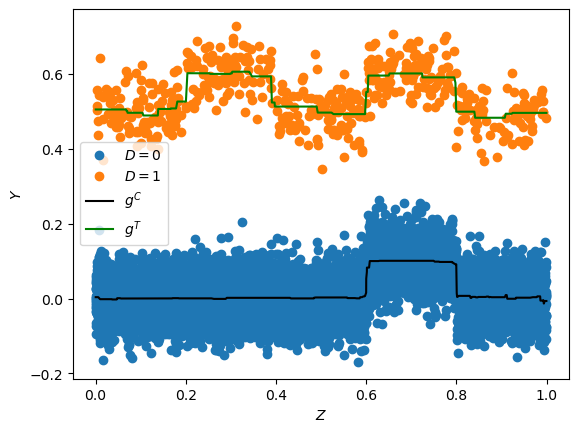

In [15]:
plt.scatter(Z[D==0], Y[D==0], label='$D=0$')
plt.scatter(Z[D==1], Y[D==1], label='$D=1$')
plt.plot(Ztest, g0.predict(Ztest.reshape(-1, 1)), color='black', label='$g^C$')
plt.plot(Ztest, g1.predict(Ztest.reshape(-1, 1)), color='green', label='$g^T$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [16]:
# propensity
mu = clf().fit(Z, D)

[0]	validation_0-logloss:0.65385
[1]	validation_0-logloss:0.61831
[2]	validation_0-logloss:0.58605
[3]	validation_0-logloss:0.55665
[4]	validation_0-logloss:0.52980
[5]	validation_0-logloss:0.50521
[6]	validation_0-logloss:0.48265
[7]	validation_0-logloss:0.46189
[8]	validation_0-logloss:0.44278
[9]	validation_0-logloss:0.42515
[10]	validation_0-logloss:0.40886
[11]	validation_0-logloss:0.39381
[12]	validation_0-logloss:0.37987
[13]	validation_0-logloss:0.36696
[14]	validation_0-logloss:0.35499
[15]	validation_0-logloss:0.34389
[16]	validation_0-logloss:0.33359
[17]	validation_0-logloss:0.32403
[18]	validation_0-logloss:0.31516
[19]	validation_0-logloss:0.30690
[20]	validation_0-logloss:0.29924
[21]	validation_0-logloss:0.29210
[22]	validation_0-logloss:0.28548
[23]	validation_0-logloss:0.27930
[24]	validation_0-logloss:0.27358
[25]	validation_0-logloss:0.26825
[26]	validation_0-logloss:0.26329
[27]	validation_0-logloss:0.25869
[28]	validation_0-logloss:0.25441
[29]	validation_0-loglos

In [17]:
# X-learner
m = mu.predict_proba(Z)[:, 1]
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0])
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]))

[0]	validation_0-rmse:0.06502
[1]	validation_0-rmse:0.06368
[2]	validation_0-rmse:0.06244
[3]	validation_0-rmse:0.06131
[4]	validation_0-rmse:0.06027
[5]	validation_0-rmse:0.05933
[6]	validation_0-rmse:0.05846
[7]	validation_0-rmse:0.05767
[8]	validation_0-rmse:0.05694
[9]	validation_0-rmse:0.05628
[10]	validation_0-rmse:0.05567
[11]	validation_0-rmse:0.05513
[12]	validation_0-rmse:0.05463
[13]	validation_0-rmse:0.05418
[14]	validation_0-rmse:0.05376
[15]	validation_0-rmse:0.05338
[16]	validation_0-rmse:0.05304
[17]	validation_0-rmse:0.05274
[18]	validation_0-rmse:0.05246
[19]	validation_0-rmse:0.05220
[20]	validation_0-rmse:0.05198
[21]	validation_0-rmse:0.05177
[22]	validation_0-rmse:0.05158
[23]	validation_0-rmse:0.05141
[24]	validation_0-rmse:0.05125
[25]	validation_0-rmse:0.05112
[26]	validation_0-rmse:0.05100
[27]	validation_0-rmse:0.05091
[28]	validation_0-rmse:0.05081
[29]	validation_0-rmse:0.05072
[30]	validation_0-rmse:0.05063
[31]	validation_0-rmse:0.05056
[32]	validation_0-

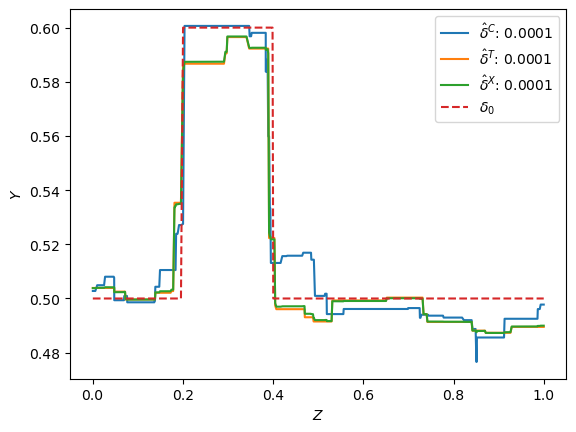

In [18]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, t0,  label='$\hat{\delta}^C$: ' + f'{rmse(cate(Ztest), t0):.4f}')
plt.plot(Ztest, t1, label='$\hat{\delta}^T$: ' + f'{rmse(cate(Ztest), t1):.4f}')
plt.plot(Ztest, tX,  label='$\hat{\delta}^X$: ' + f'{rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label='$\delta_0$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [19]:
# S-Learner
g = reg().fit(np.hstack([D.reshape(-1, 1), Z]), Y)

[0]	validation_0-rmse:0.44901
[1]	validation_0-rmse:0.42692
[2]	validation_0-rmse:0.40596
[3]	validation_0-rmse:0.38606
[4]	validation_0-rmse:0.36719
[5]	validation_0-rmse:0.34928
[6]	validation_0-rmse:0.33229
[7]	validation_0-rmse:0.31618
[8]	validation_0-rmse:0.30090
[9]	validation_0-rmse:0.28640
[10]	validation_0-rmse:0.27267
[11]	validation_0-rmse:0.25963
[12]	validation_0-rmse:0.24729
[13]	validation_0-rmse:0.23558
[14]	validation_0-rmse:0.22450
[15]	validation_0-rmse:0.21400
[16]	validation_0-rmse:0.20406
[17]	validation_0-rmse:0.19464
[18]	validation_0-rmse:0.18574
[19]	validation_0-rmse:0.17731
[20]	validation_0-rmse:0.16935
[21]	validation_0-rmse:0.16181
[22]	validation_0-rmse:0.15471
[23]	validation_0-rmse:0.14799
[24]	validation_0-rmse:0.14167
[25]	validation_0-rmse:0.13568
[26]	validation_0-rmse:0.13006
[27]	validation_0-rmse:0.12475
[28]	validation_0-rmse:0.11977
[29]	validation_0-rmse:0.11506
[30]	validation_0-rmse:0.11067
[31]	validation_0-rmse:0.10651
[32]	validation_0-

In [20]:
# IPS-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauIPS = reg().fit(Z, Y * (D - m)/cov)

[0]	validation_0-rmse:2.16399
[1]	validation_0-rmse:2.16409
[2]	validation_0-rmse:2.16417
[3]	validation_0-rmse:2.16428
[4]	validation_0-rmse:2.16437


In [21]:
# DR-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Z)
g0preds = g0.predict(Z)
gpreds = g1preds * D + g0preds * (1 - D)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDR = reg().fit(Z, Ydr)

[0]	validation_0-rmse:0.20112
[1]	validation_0-rmse:0.20069
[2]	validation_0-rmse:0.20030
[3]	validation_0-rmse:0.19995
[4]	validation_0-rmse:0.19963
[5]	validation_0-rmse:0.19935
[6]	validation_0-rmse:0.19909
[7]	validation_0-rmse:0.19886
[8]	validation_0-rmse:0.19865
[9]	validation_0-rmse:0.19845
[10]	validation_0-rmse:0.19829
[11]	validation_0-rmse:0.19813
[12]	validation_0-rmse:0.19799
[13]	validation_0-rmse:0.19790
[14]	validation_0-rmse:0.19777
[15]	validation_0-rmse:0.19767
[16]	validation_0-rmse:0.19760
[17]	validation_0-rmse:0.19751
[18]	validation_0-rmse:0.19743
[19]	validation_0-rmse:0.19736
[20]	validation_0-rmse:0.19731
[21]	validation_0-rmse:0.19724
[22]	validation_0-rmse:0.19720
[23]	validation_0-rmse:0.19714
[24]	validation_0-rmse:0.19710
[25]	validation_0-rmse:0.19706
[26]	validation_0-rmse:0.19703
[27]	validation_0-rmse:0.19699
[28]	validation_0-rmse:0.19696
[29]	validation_0-rmse:0.19694
[30]	validation_0-rmse:0.19692
[31]	validation_0-rmse:0.19690
[32]	validation_0-

In [22]:
# R-Learner
h = reg().fit(Z, Y)
Yres = Y - h.predict(Z)
Dres = D - mu.predict_proba(Z)[:, 1]

[0]	validation_0-rmse:0.45220
[1]	validation_0-rmse:0.43141
[2]	validation_0-rmse:0.41173
[3]	validation_0-rmse:0.39312
[4]	validation_0-rmse:0.37553
[5]	validation_0-rmse:0.35891
[6]	validation_0-rmse:0.34320
[7]	validation_0-rmse:0.32837
[8]	validation_0-rmse:0.31439
[9]	validation_0-rmse:0.30120
[10]	validation_0-rmse:0.28877
[11]	validation_0-rmse:0.27706
[12]	validation_0-rmse:0.26605
[13]	validation_0-rmse:0.25569
[14]	validation_0-rmse:0.24597
[15]	validation_0-rmse:0.23684
[16]	validation_0-rmse:0.22828
[17]	validation_0-rmse:0.22026
[18]	validation_0-rmse:0.21275
[19]	validation_0-rmse:0.20574
[20]	validation_0-rmse:0.19919
[21]	validation_0-rmse:0.19308
[22]	validation_0-rmse:0.18738
[23]	validation_0-rmse:0.18209
[24]	validation_0-rmse:0.17717
[25]	validation_0-rmse:0.17260
[26]	validation_0-rmse:0.16836
[27]	validation_0-rmse:0.16444
[28]	validation_0-rmse:0.16082
[29]	validation_0-rmse:0.15747
[30]	validation_0-rmse:0.15438
[31]	validation_0-rmse:0.15153
[32]	validation_0-

In [23]:
DresClip = np.clip(Dres, 1e-12, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-12) * (Dres<0)
tauR = reg().fit(Z, Yres/DresClip, sample_weight=Dres**2)

[0]	validation_0-rmse:0.22521
[1]	validation_0-rmse:0.22484
[2]	validation_0-rmse:0.22450
[3]	validation_0-rmse:0.22420
[4]	validation_0-rmse:0.22392
[5]	validation_0-rmse:0.22366
[6]	validation_0-rmse:0.22343
[7]	validation_0-rmse:0.22321
[8]	validation_0-rmse:0.22302
[9]	validation_0-rmse:0.22285
[10]	validation_0-rmse:0.22269
[11]	validation_0-rmse:0.22254
[12]	validation_0-rmse:0.22241
[13]	validation_0-rmse:0.22229
[14]	validation_0-rmse:0.22218
[15]	validation_0-rmse:0.22208
[16]	validation_0-rmse:0.22198
[17]	validation_0-rmse:0.22193
[18]	validation_0-rmse:0.22185
[19]	validation_0-rmse:0.22177
[20]	validation_0-rmse:0.22170
[21]	validation_0-rmse:0.22164
[22]	validation_0-rmse:0.22161
[23]	validation_0-rmse:0.22156
[24]	validation_0-rmse:0.22151
[25]	validation_0-rmse:0.22148
[26]	validation_0-rmse:0.22144
[27]	validation_0-rmse:0.22141
[28]	validation_0-rmse:0.22139
[29]	validation_0-rmse:0.22135
[30]	validation_0-rmse:0.22134
[31]	validation_0-rmse:0.22131
[32]	validation_0-

In [24]:
# from econml.grf import CausalForest
# tauR = CausalForest(min_samples_leaf=20, max_depth=5, max_samples=.8, inference=False).fit(Z, Dres, Yres)

In [25]:
# DRX-Learner
m = mu.predict_proba(Z)[:, 1]
g0preds = g0.predict(Z)
g1preds = g1.predict(Z)
g0preds = g0preds * (1 - m) + (g1.predict(Z) - tau0.predict(Z)) * m
g1preds = g1preds * m + (g0.predict(Z) + tau1.predict(Z)) * (1 - m)
gpreds = g1preds * D + g0preds * (1 - D)
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDRX = reg().fit(Z, Ydr)

[0]	validation_0-rmse:0.20647
[1]	validation_0-rmse:0.20605
[2]	validation_0-rmse:0.20568
[3]	validation_0-rmse:0.20534
[4]	validation_0-rmse:0.20504
[5]	validation_0-rmse:0.20478
[6]	validation_0-rmse:0.20454
[7]	validation_0-rmse:0.20432
[8]	validation_0-rmse:0.20413
[9]	validation_0-rmse:0.20396
[10]	validation_0-rmse:0.20381
[11]	validation_0-rmse:0.20366
[12]	validation_0-rmse:0.20354
[13]	validation_0-rmse:0.20344
[14]	validation_0-rmse:0.20334
[15]	validation_0-rmse:0.20325
[16]	validation_0-rmse:0.20319
[17]	validation_0-rmse:0.20312
[18]	validation_0-rmse:0.20306
[19]	validation_0-rmse:0.20302
[20]	validation_0-rmse:0.20297
[21]	validation_0-rmse:0.20295
[22]	validation_0-rmse:0.20292
[23]	validation_0-rmse:0.20292
[24]	validation_0-rmse:0.20289
[25]	validation_0-rmse:0.20287
[26]	validation_0-rmse:0.20288
[27]	validation_0-rmse:0.20285
[28]	validation_0-rmse:0.20284
[29]	validation_0-rmse:0.20286
[30]	validation_0-rmse:0.20284
[31]	validation_0-rmse:0.20283
[32]	validation_0-

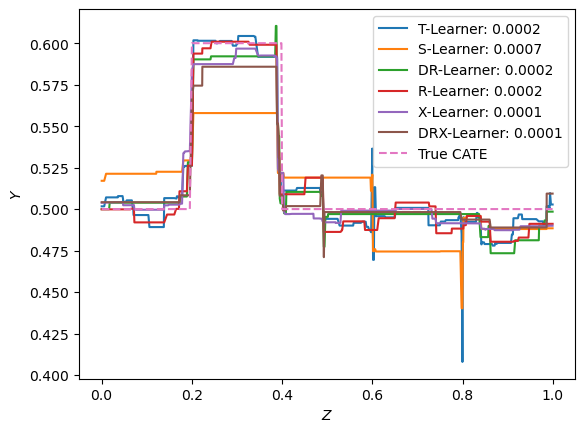

In [26]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
tT = g1.predict(Ztest.reshape(-1, 1)) - g0.predict(Ztest.reshape(-1, 1))
tS = g.predict(np.stack((np.ones(ntest), Ztest), -1)) - g.predict(np.stack((np.zeros(ntest), Ztest), -1))
tIPS = tauIPS.predict(Ztest.reshape(-1, 1))
tDR = tauDR.predict(Ztest.reshape(-1, 1))
tR = tauR.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
plt.plot(Ztest, tT, label=f'T-Learner: {rmse(cate(Ztest), tT):.4f}')
plt.plot(Ztest, tS, label=f'S-Learner: {rmse(cate(Ztest), tS):.4f}')
# plt.plot(Ztest, tIPS, label='IPS-Learner')
plt.plot(Ztest, tDR, label=f'DR-Learner: {rmse(cate(Ztest), tDR):.4f}')
plt.plot(Ztest, tR, label=f'R-Learner: {rmse(cate(Ztest), tR):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [27]:
import scipy

def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss

def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K)/K, jac=grad_q, bounds=[(0, 1)]*K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-12)
    return res.x

def qagg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)

In [28]:
def staragg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    sol = np.zeros(F.shape[1])
    best = np.argmin(ploss)
    sol[best] = 1.0
    best_loss = loss(sol)
    best_sol = sol
    for gamma in np.linspace(0, 1, 100):
        for i in range(F.shape[1]):
            x = (1 - gamma) * sol
            x[i] += gamma
            cur_loss = loss(x)
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_sol = x
    return best_sol

In [29]:
Zval = np.random.uniform(0, 1, size=n)
Dval = np.random.binomial(1, prop(Zval))
Yval = cate(Zval) * Dval + base(Zval) + np.random.normal(0, .05, size=n)

In [30]:
Zval = Zval.reshape(-1, 1)
g0val = reg().fit(Zval[Dval==0], Yval[Dval==0])
g1val = reg().fit(Zval[Dval==1], Yval[Dval==1])
muval = clf().fit(Zval, Dval)
# DR-Learner
m = muval.predict_proba(Zval)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1val.predict(Zval)
g0preds = g0val.predict(Zval)
gpreds = g1preds * Dval + g0preds * (1 - Dval)
Ydrval = (Yval - gpreds) * (Dval - m)/cov + g1preds - g0preds

[0]	validation_0-rmse:0.46066
[1]	validation_0-rmse:0.43799
[2]	validation_0-rmse:0.41646
[3]	validation_0-rmse:0.39602
[4]	validation_0-rmse:0.37662
[5]	validation_0-rmse:0.35822
[6]	validation_0-rmse:0.34074
[7]	validation_0-rmse:0.32416
[8]	validation_0-rmse:0.30842
[9]	validation_0-rmse:0.29350
[10]	validation_0-rmse:0.27935
[11]	validation_0-rmse:0.26592
[12]	validation_0-rmse:0.25319
[13]	validation_0-rmse:0.24113
[14]	validation_0-rmse:0.22969
[15]	validation_0-rmse:0.21885
[16]	validation_0-rmse:0.20858
[17]	validation_0-rmse:0.19886
[18]	validation_0-rmse:0.18966
[19]	validation_0-rmse:0.18094
[20]	validation_0-rmse:0.17270
[21]	validation_0-rmse:0.16490
[22]	validation_0-rmse:0.15753
[23]	validation_0-rmse:0.15057
[24]	validation_0-rmse:0.14399
[25]	validation_0-rmse:0.13778
[26]	validation_0-rmse:0.13193
[27]	validation_0-rmse:0.12641
[28]	validation_0-rmse:0.12121
[29]	validation_0-rmse:0.11631
[30]	validation_0-rmse:0.11171
[31]	validation_0-rmse:0.10739
[32]	validation_0-

[45]	validation_0-logloss:0.21173
[46]	validation_0-logloss:0.21061
[47]	validation_0-logloss:0.20959
[48]	validation_0-logloss:0.20862
[49]	validation_0-logloss:0.20776
[50]	validation_0-logloss:0.20694
[51]	validation_0-logloss:0.20618
[52]	validation_0-logloss:0.20550
[53]	validation_0-logloss:0.20486
[54]	validation_0-logloss:0.20429
[55]	validation_0-logloss:0.20374
[56]	validation_0-logloss:0.20324
[57]	validation_0-logloss:0.20280
[58]	validation_0-logloss:0.20235
[59]	validation_0-logloss:0.20198
[60]	validation_0-logloss:0.20160
[61]	validation_0-logloss:0.20125
[62]	validation_0-logloss:0.20095
[63]	validation_0-logloss:0.20066
[64]	validation_0-logloss:0.20039
[65]	validation_0-logloss:0.20015
[66]	validation_0-logloss:0.19993
[67]	validation_0-logloss:0.19973
[68]	validation_0-logloss:0.19953
[69]	validation_0-logloss:0.19938
[70]	validation_0-logloss:0.19922
[71]	validation_0-logloss:0.19907
[72]	validation_0-logloss:0.19896
[73]	validation_0-logloss:0.19883
[74]	validatio

In [31]:
t0 = tau0.predict(Zval)
t1 = tau1.predict(Zval)
tT = g1.predict(Zval) - g0.predict(Zval)
tS = g.predict(np.stack((np.ones(n), Zval.flatten()), -1))
tS -= g.predict(np.stack((np.zeros(n), Zval.flatten()), -1))
tIPS = tauIPS.predict(Zval)
tDR = tauDR.predict(Zval)
tR = tauR.predict(Zval)
m = mu.predict_proba(Zval)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zval)

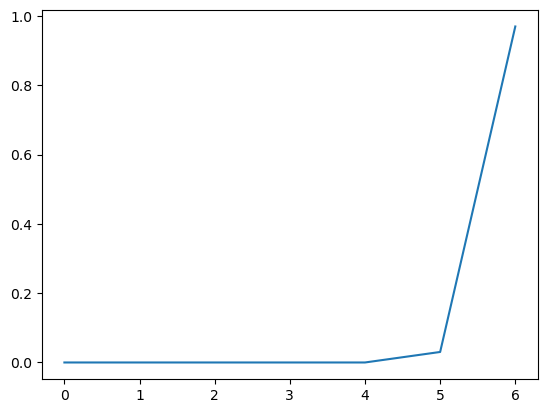

In [32]:
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
weights = qagg(F, Ydrval)
plt.plot(weights)
# weights = staragg(F, Ydrval)
# plt.plot(weights)

In [33]:
f'Ensemble: {rmse(cate(Zval.flatten()), F @ weights):.4f}'

'Ensemble: 0.0001'

In [34]:
weightsBest = np.zeros(weights.shape)
weightsBest[np.argmin(np.mean((Ydrval.reshape(-1, 1) - F)**2, axis=0))] = 1.0
f'Ensemble: {rmse(cate(Zval.flatten()), F @ weightsBest):.4f}'

'Ensemble: 0.0001'

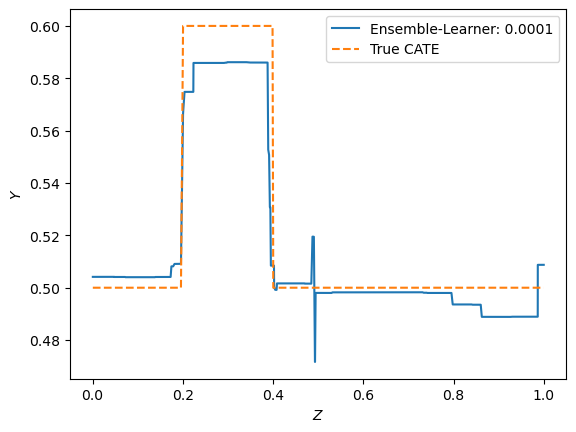

In [35]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
tT = g1.predict(Ztest.reshape(-1, 1)) - g0.predict(Ztest.reshape(-1, 1))
tS = g.predict(np.stack((np.ones(ntest), Ztest), -1)) - g.predict(np.stack((np.zeros(ntest), Ztest), -1))
tIPS = tauIPS.predict(Ztest.reshape(-1, 1))
tDR = tauDR.predict(Ztest.reshape(-1, 1))
tR = tauR.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
tE = F @ weights
plt.plot(Ztest, tE, label=f'Ensemble-Learner: {rmse(cate(Ztest), tE):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [36]:
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauDRXW = reg().fit(Z, Ydr, sample_weight=cov**2)

[0]	validation_0-rmse:0.21841
[1]	validation_0-rmse:0.21835
[2]	validation_0-rmse:0.21829
[3]	validation_0-rmse:0.21824
[4]	validation_0-rmse:0.21819
[5]	validation_0-rmse:0.21814
[6]	validation_0-rmse:0.21810
[7]	validation_0-rmse:0.21806
[8]	validation_0-rmse:0.21803
[9]	validation_0-rmse:0.21800
[10]	validation_0-rmse:0.21797
[11]	validation_0-rmse:0.21794
[12]	validation_0-rmse:0.21791
[13]	validation_0-rmse:0.21789
[14]	validation_0-rmse:0.21787
[15]	validation_0-rmse:0.21785
[16]	validation_0-rmse:0.21783
[17]	validation_0-rmse:0.21781
[18]	validation_0-rmse:0.21780
[19]	validation_0-rmse:0.21778
[20]	validation_0-rmse:0.21777
[21]	validation_0-rmse:0.21775
[22]	validation_0-rmse:0.21774
[23]	validation_0-rmse:0.21773
[24]	validation_0-rmse:0.21772
[25]	validation_0-rmse:0.21771
[26]	validation_0-rmse:0.21770
[27]	validation_0-rmse:0.21769
[28]	validation_0-rmse:0.21769
[29]	validation_0-rmse:0.21768
[30]	validation_0-rmse:0.21767
[31]	validation_0-rmse:0.21767
[32]	validation_0-

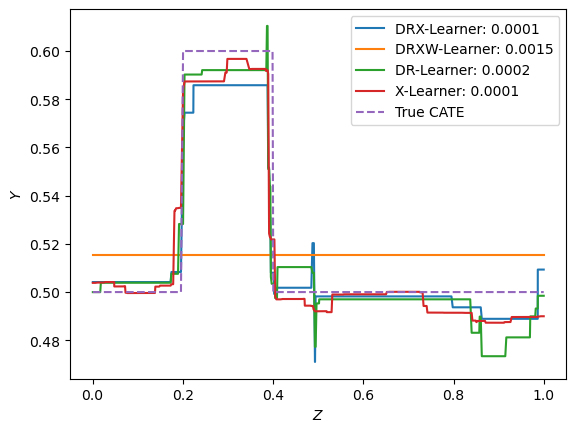

In [37]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
tDRXW = tauDRXW.predict(Ztest.reshape(-1, 1))
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, tDRXW, label=f'DRXW-Learner: {rmse(cate(Ztest), tDRXW):.4f}')
plt.plot(Ztest, tDR, label=f'DR-Learner: {rmse(cate(Ztest), tDR):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [38]:
# post-processing DRX
m = mu.predict_proba(Z)[:, 1]
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
tX = t1 * (1 - m) + t0 * m
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = tX + (Yres - tX * Dres) * Dres / cov
tauDRX = reg().fit(Z, Ydr)

[0]	validation_0-rmse:0.21908
[1]	validation_0-rmse:0.21869
[2]	validation_0-rmse:0.21826
[3]	validation_0-rmse:0.21788
[4]	validation_0-rmse:0.21753
[5]	validation_0-rmse:0.21722
[6]	validation_0-rmse:0.21698
[7]	validation_0-rmse:0.21672
[8]	validation_0-rmse:0.21648
[9]	validation_0-rmse:0.21626
[10]	validation_0-rmse:0.21606
[11]	validation_0-rmse:0.21588
[12]	validation_0-rmse:0.21575
[13]	validation_0-rmse:0.21560
[14]	validation_0-rmse:0.21546
[15]	validation_0-rmse:0.21534
[16]	validation_0-rmse:0.21524
[17]	validation_0-rmse:0.21517
[18]	validation_0-rmse:0.21510
[19]	validation_0-rmse:0.21501
[20]	validation_0-rmse:0.21494
[21]	validation_0-rmse:0.21490
[22]	validation_0-rmse:0.21484
[23]	validation_0-rmse:0.21478
[24]	validation_0-rmse:0.21474
[25]	validation_0-rmse:0.21475
[26]	validation_0-rmse:0.21470
[27]	validation_0-rmse:0.21466
[28]	validation_0-rmse:0.21467
[29]	validation_0-rmse:0.21462
[30]	validation_0-rmse:0.21464
[31]	validation_0-rmse:0.21461
[32]	validation_0-

In [39]:
# post-processing RX
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
m = mu.predict_proba(Z)[:, 1]
tX = t1 * (1 - m) + t0 * m
tauRX = reg().fit(Z, (Yres - tX * Dres) / DresClip, sample_weight=Dres**2)

[0]	validation_0-rmse:0.52983
[1]	validation_0-rmse:0.50862
[2]	validation_0-rmse:0.48867
[3]	validation_0-rmse:0.46992
[4]	validation_0-rmse:0.45231
[5]	validation_0-rmse:0.43579
[6]	validation_0-rmse:0.42031
[7]	validation_0-rmse:0.40581
[8]	validation_0-rmse:0.39225
[9]	validation_0-rmse:0.37958
[10]	validation_0-rmse:0.36775
[11]	validation_0-rmse:0.35673
[12]	validation_0-rmse:0.34647
[13]	validation_0-rmse:0.33692
[14]	validation_0-rmse:0.32806
[15]	validation_0-rmse:0.31983
[16]	validation_0-rmse:0.31221
[17]	validation_0-rmse:0.30515
[18]	validation_0-rmse:0.29863
[19]	validation_0-rmse:0.29261
[20]	validation_0-rmse:0.28705
[21]	validation_0-rmse:0.28194
[22]	validation_0-rmse:0.27723
[23]	validation_0-rmse:0.27290
[24]	validation_0-rmse:0.26892
[25]	validation_0-rmse:0.26527
[26]	validation_0-rmse:0.26193
[27]	validation_0-rmse:0.25886
[28]	validation_0-rmse:0.25606
[29]	validation_0-rmse:0.25349
[30]	validation_0-rmse:0.25115
[31]	validation_0-rmse:0.24903
[32]	validation_0-

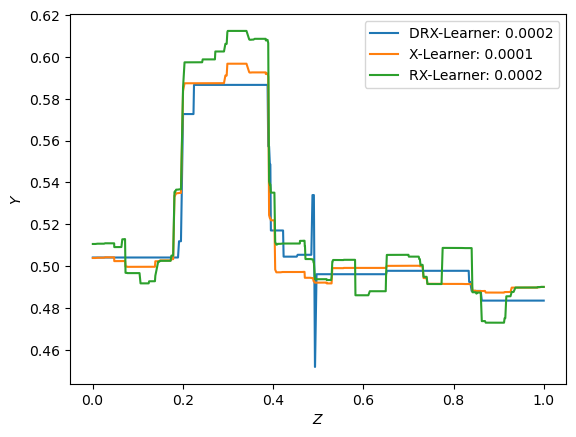

In [40]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
tX = t1 * (1 - m) + t0 * m
tRX = tauRX.predict(Ztest.reshape(-1, 1)) + tX
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, tRX, label=f'RX-Learner: {rmse(cate(Ztest), tRX):.4f}')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [41]:
# correcting for covariate shift in CATE model estimation in X-Learner
m = mu.predict_proba(Z)[:, 1]

g0 = reg().fit(Z[D==0], Y[D==0], sample_weight=(1 - m[D==0]))
g1 = reg().fit(Z[D==1], Y[D==1], sample_weight=m[D==1])
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0], sample_weight=m[D==0]**2 / (1 - m[D==0]))
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]), sample_weight=(1 - m[D==1])**2 / m[D==1])

[0]	validation_0-rmse:0.45941
[1]	validation_0-rmse:0.43664
[2]	validation_0-rmse:0.41502
[3]	validation_0-rmse:0.39450
[4]	validation_0-rmse:0.37502
[5]	validation_0-rmse:0.35653
[6]	validation_0-rmse:0.33898
[7]	validation_0-rmse:0.32233
[8]	validation_0-rmse:0.30653
[9]	validation_0-rmse:0.29154
[10]	validation_0-rmse:0.27732
[11]	validation_0-rmse:0.26384
[12]	validation_0-rmse:0.25106
[13]	validation_0-rmse:0.23894
[14]	validation_0-rmse:0.22745
[15]	validation_0-rmse:0.21656
[16]	validation_0-rmse:0.20625
[17]	validation_0-rmse:0.19648
[18]	validation_0-rmse:0.18723
[19]	validation_0-rmse:0.17848
[20]	validation_0-rmse:0.17020
[21]	validation_0-rmse:0.16237
[22]	validation_0-rmse:0.15497
[23]	validation_0-rmse:0.14798
[24]	validation_0-rmse:0.14137
[25]	validation_0-rmse:0.13514
[26]	validation_0-rmse:0.12927
[27]	validation_0-rmse:0.12373
[28]	validation_0-rmse:0.11851
[29]	validation_0-rmse:0.11361
[30]	validation_0-rmse:0.10899
[31]	validation_0-rmse:0.10466
[32]	validation_0-

[37]	validation_0-rmse:0.05211
[38]	validation_0-rmse:0.05209
[39]	validation_0-rmse:0.05215
[40]	validation_0-rmse:0.05213


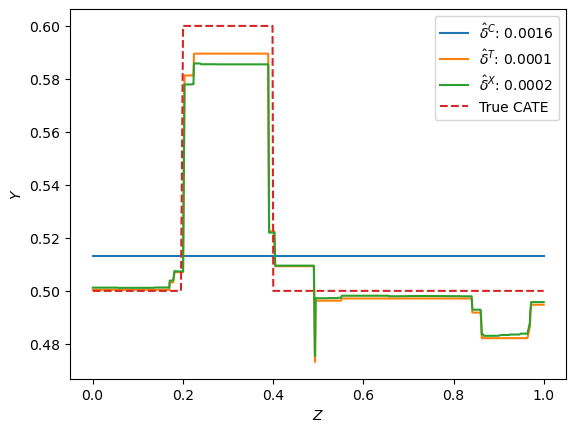

In [42]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, t0,  label='$\hat{\delta}^C$: ' + f'{rmse(cate(Ztest), t0):.4f}')
plt.plot(Ztest, t1, label='$\hat{\delta}^T$: ' + f'{rmse(cate(Ztest), t1):.4f}')
plt.plot(Ztest, tX,  label='$\hat{\delta}^X$: ' + f'{rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [43]:
# from sklearn.model_selection import cross_val_predict, KFold

# m = cross_val_predict(clf(), Z, D, method='predict_proba')[:, 1]
# g0preds, g1preds = np.zeros(Y.shape), np.zeros(Y.shape)
# for train, test in KFold().split(Z, D):
#     g1preds[test] = reg().fit(Z[train][D[train]==1], Y[train][D[train]==1]).predict(Z[test])
#     g0preds[test] = reg().fit(Z[train][D[train]==0], Y[train][D[train]==0]).predict(Z[test])

# gpreds = g1preds * D + g0preds * (1 - D)
# Ydr = (Y - gpreds) * (D - m)/(m * (1 - m)) + g1preds - g0preds
# tauDR = reg().fit(Z, Ydr)

In [44]:
# grid = np.linspace(0, 1, 20)

# t0 = tau0.predict(grid.reshape(-1, 1))
# t1 = tau1.predict(grid.reshape(-1, 1))
# tDR = tauDR.predict(grid.reshape(-1, 1))
# m = mu.predict_proba(grid.reshape(-1, 1))[:, 1]
# plt.plot(grid, tDR, label='DR-Learner')
# plt.plot(grid, t1 * (1 - m) + t0 * m,  label='X-Learner')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()